Chọn 1 bộ dữ liệu time-series bất kì trong đây link text ([Liên kết đến một trang bên ngoài.](https://github.com/thieu1995/csv-files)), và lấy ra một cột time-series, xây dựng mô hình dự đoán dùng AR, MA, ARMA và ARIMA models.

Với yêu cầu các models bên trên phải được tối ưu hóa tham số mô hình, các mô hình được so sánh dựa trên giá trị AIC. Model nào có giá trị AIC càng nhỏ thì càng tốt. Tối ưu tham số bằng cách duyệt những giá trị có thể dùng for.

Sau đó so sánh kêt quả của 4 models đã được tối ưu tham số từ 4 mô hình bên trên dựa vào giá trị RMSE của tập test. 

In [17]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA, ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from sklearn.metrics import mean_squared_error

In [23]:
data_path = "Water_Spring_Madonna_di_Canneto.csv"
col = "Flow_Rate_Madonna_di_Canneto"

In [57]:
def get_df():
    df = pd.read_csv(data_path)
    df.head()
    df = df[['Date',col]]
    df['Date'] = pd.to_datetime(df['Date'], format = "%d/%m/%Y")
    df['Year'] = df.Date.dt.year
    df['Month'] = df.Date.dt.month
    return df

df = get_df()
df.dropna(inplace=True)
df.head(10)

,Date,Flow_Rate_Madonna_di_Canneto,Year,Month
1167,2015-03-13,255.956525,2015.0,3.0
1168,2015-03-14,289.545561,2015.0,3.0
1169,2015-03-15,289.918615,2015.0,3.0
1170,2015-03-16,290.082896,2015.0,3.0
1171,2015-03-17,290.688777,2015.0,3.0
1172,2015-03-18,285.417723,2015.0,3.0
1173,2015-03-19,282.244360,2015.0,3.0
1174,2015-03-20,283.489918,2015.0,3.0
1175,2015-03-21,283.920394,2015.0,3.0
1176,2015-03-22,284.327247,2015.0,3.0


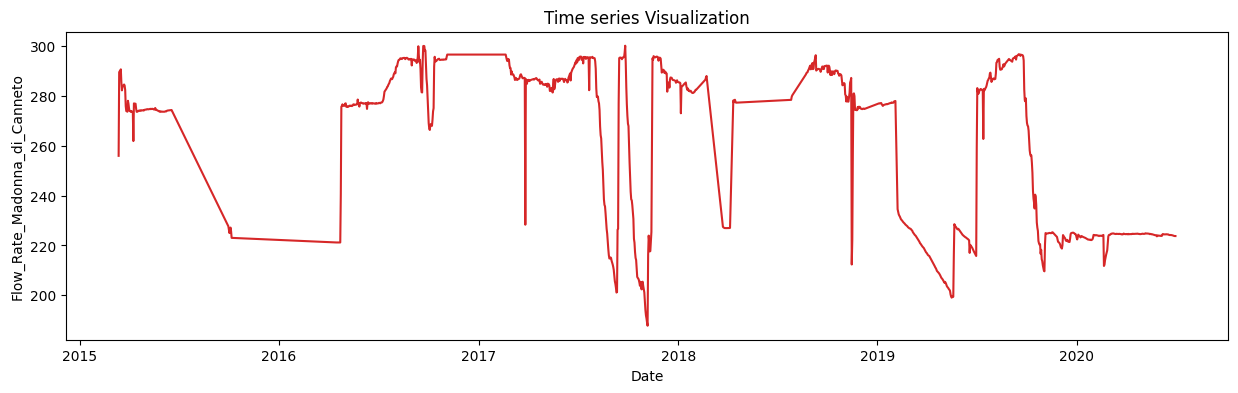

In [46]:
def plot_df(df, x, y, title="", xlabel='Date', ylabel=col, dpi=100, color="blue"):
    plt.figure(figsize=(15,4), dpi=dpi)
    plt.plot(x, y, color=color)
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(df, x=df['Date'], y=df[col], title='Time series Visualization', color="tab:red")

In [48]:
df2 = df.groupby(['Year', 'Month'])[col].mean().reset_index()
df2.head(12)

,Year,Month,Flow_Rate_Madonna_di_Canneto
0,2015.0,3.0,281.008348
1,2015.0,4.0,274.033177
2,2015.0,5.0,274.424225
3,2015.0,6.0,273.830419
4,2015.0,9.0,227.673440
5,2015.0,10.0,225.193333
6,2016.0,4.0,248.098025
7,2016.0,5.0,276.455001
8,2016.0,6.0,276.945709
9,2016.0,7.0,282.704710


In [49]:
df3 = df2.pivot(index='Month', columns='Year', values=col)
#df3.fillna(df3.mean(), inplace=True)
df3

Year,2015.0,2016.0,2017.0,2018.0,2019.0,2020.0
Month,,,,,,
1.0,NaN,NaN,296.607544,282.990099,276.874586,222.966037
2.0,NaN,NaN,295.654984,284.834239,235.492828,221.681486
3.0,281.008348,NaN,285.477305,227.064483,222.311523,224.586048
4.0,274.033177,248.098025,286.077509,252.440742,211.877236,224.593341
5.0,274.424225,276.455001,284.775329,NaN,210.974755,224.422496
6.0,273.830419,276.945709,288.819704,NaN,221.461035,224.155529
7.0,NaN,282.704710,294.819131,279.429906,280.311221,NaN
8.0,NaN,294.263710,250.723146,290.285534,291.479335,NaN
9.0,227.673440,292.239060,256.363353,291.684860,292.871003,NaN


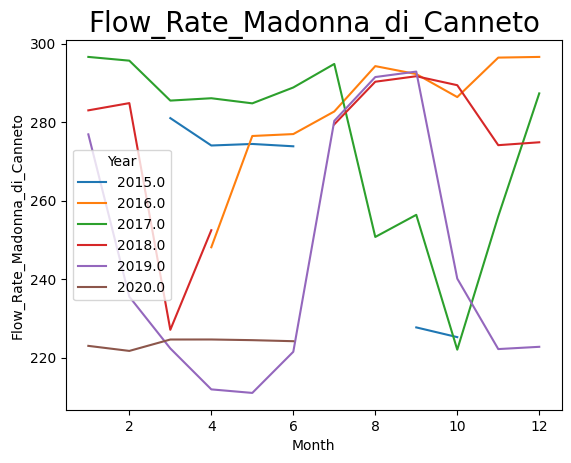

In [50]:
df3.plot()
plt.title(col, fontsize=20)
plt.ylabel(col)
plt.show()

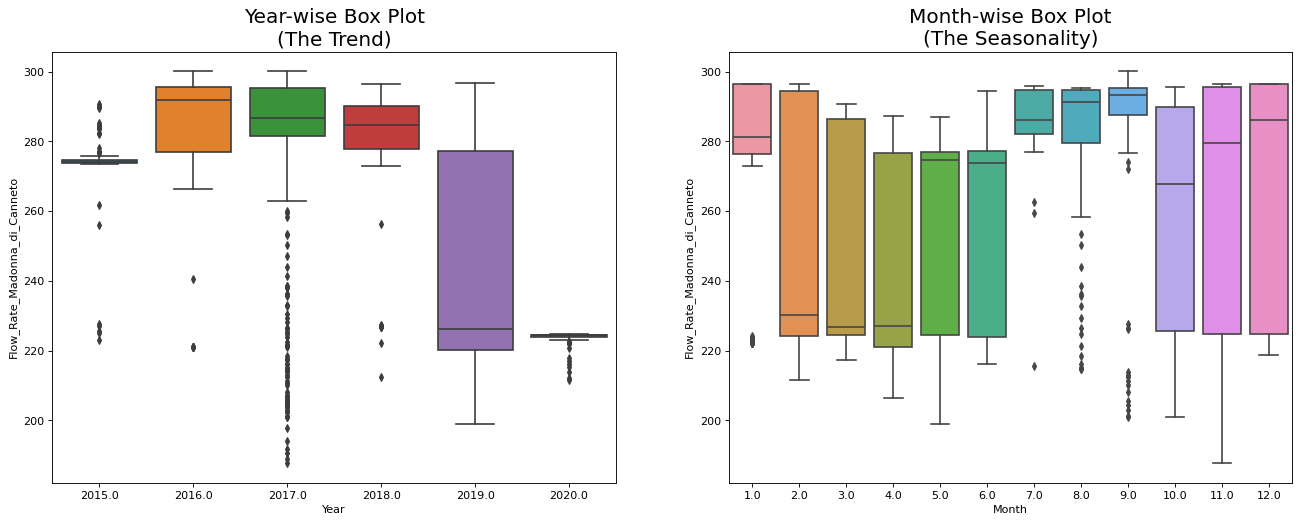

In [51]:
# Draw Plot
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='Year', y=col, data=df, ax=axes[0])
sns.boxplot(x='Month', y=col, data=df)

# Set Title
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18);
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

In [58]:
# First Order Differencing
ts_diff = np.diff(df[col])
data = np.append([0], ts_diff)
size_dataset = len(data)
train, test = data[:int(0.8*size_dataset)], data[int(0.8*size_dataset):]

## AR (Autoregressive) model

In [60]:
from statsmodels.tsa.ar_model import AutoReg

# Fit the AutoReg model on the training data
model = AutoReg(train, lags=5)      # lags = (1, 2, 3, 4, 5)
model_01 = model.fit()             # get the fitted model.

# Print the model summary
print(model_01.summary())
print('AIC: {0:0.3f}, HQIC: {1:0.3f}, BIC: {2:0.3f}'.format(model_01.aic, model_01.hqic, model_01.bic))

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                 1109
Model:                     AutoReg(5)   Log Likelihood               -3551.974
Method:               Conditional MLE   S.D. of innovations              6.040
Date:                Thu, 30 May 2024   AIC                           7117.948
Time:                        19:06:13   BIC                           7152.995
Sample:                             5   HQIC                          7131.204
                                 1109                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0048      0.182      0.027      0.979      -0.351       0.361
y.L1           0.0380      0.030      1.262      0.207      -0.021       0.097
y.L2          -0.0145      0.030     -0.481      0.6

In [61]:
from permetrics import RegressionMetric

def get_ar_model_results(data_length=None, train=None, test=None, lags=3, seasonal=False, period=12):
    model = AutoReg(train, lags=lags, seasonal=seasonal, period=period)
    model_results = model.fit()
    # Results on training set
    res_train = {
        "aic": model_results.aic,
        "hqic": model_results.hqic,
        "bic": model_results.bic,
    }

    ## Results on testing set
    pred = model_results.predict(start=len(train), end=data_length-1, dynamic=False)
    evaluator = RegressionMetric(test, pred)
    res_test = evaluator.get_metrics_by_list_names(["RMSE", "MAE", "MAPE", "R2", "NSE", "KGE"])

    return {**res_train, **res_test}


list_lags = [3, 6, 9, 12]
list_seasonal = [True, False]
list_period = [6, 12, 18, 24]
best_lags = 3
best_seasonal = True
best_period = 6
best_aic = None

for id_lag, lags in enumerate(list_lags):
    for id_ss, seasonal in enumerate(list_seasonal):
        for id_period, period in enumerate(list_period):
            res = get_ar_model_results(len(data), train, test, lags, seasonal, period)
            print(f"Lag={lags}, Seasonal={seasonal}, Period={period}, {res}")
            if best_aic is None or best_aic > res['aic']:
                best_aic = res['aic']
                best_lags = lags
                best_seasonal = seasonal
                best_period = period

Lag=3, Seasonal=True, Period=6, {'aic': 7128.570135535061, 'hqic': 7147.512624285468, 'bic': 7178.655187355884, 'RMSE': 1.827653999846705, 'MAE': 0.9127167775619092, 'MAPE': 12.773435361056661, 'R2': -0.09815872112425827, 'NSE': -0.09815872112425827, 'KGE': -7.66718355142382}
Lag=3, Seasonal=True, Period=12, {'aic': 7136.27721821391, 'hqic': 7166.58520021456, 'bic': 7216.413301127226, 'RMSE': 1.8807679400075619, 'MAE': 0.9962834610879566, 'MAPE': 16.33736174941753, 'R2': -0.16291394574753992, 'NSE': -0.16291394574753992, 'KGE': -9.188795713876157}
Lag=3, Seasonal=True, Period=18, {'aic': 7139.175285042047, 'hqic': 7180.848760292942, 'bic': 7249.362399047857, 'RMSE': 1.9186822549741458, 'MAE': 1.1141211298050484, 'MAPE': 23.3249223350949, 'R2': -0.21027279290877887, 'NSE': -0.21027279290877887, 'KGE': -10.801250905348603}
Lag=3, Seasonal=True, Period=24, {'aic': 7149.903597375391, 'hqic': 7202.942565876529, 'bic': 7290.141742473695, 'RMSE': 1.972015255549817, 'MAE': 1.1437693797149429, 

Coefficients: [ 0.01154084  0.03555401 -0.01488968 -0.0307803   0.00184558  0.00751867
  0.0252447   0.03931618  0.02744487 -0.00045394  0.00448801  0.00085509
 -0.04119781]
predicted=-0.010074, expected=-1.288589
predicted=0.011179, expected=1.284178
predicted=0.035432, expected=0.877061
predicted=-0.042860, expected=-0.108655
predicted=0.037103, expected=-0.009529
predicted=0.069452, expected=-0.568806
predicted=-0.012686, expected=0.484477
predicted=0.006203, expected=-0.087076
predicted=0.006691, expected=-0.044290
predicted=0.012190, expected=-0.051803
predicted=0.001882, expected=-0.475973
predicted=0.001074, expected=-1.682698
predicted=0.015266, expected=-11.651334
predicted=0.013007, expected=-4.290497
predicted=0.010541, expected=-0.471296
predicted=0.014124, expected=1.225192
predicted=0.010703, expected=-7.056144
predicted=0.009114, expected=-2.809971
predicted=0.012420, expected=-1.013767
predicted=0.012385, expected=-0.343066
predicted=0.012581, expected=-1.768938
predict

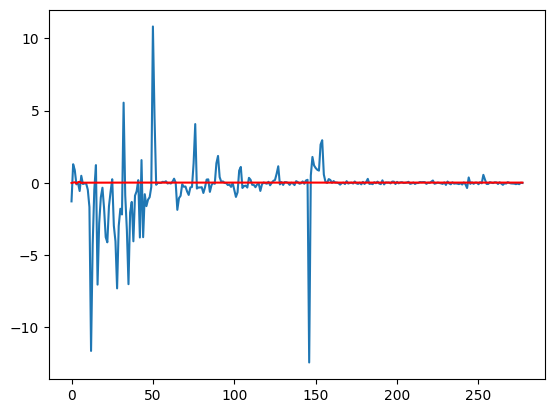

In [62]:
# create and evaluate a static autoregressive model
from statsmodels.tsa.ar_model import AutoReg
import numpy as np

# train autoregression
model = AutoReg(train, lags=best_lags, seasonal=best_seasonal, period = best_period)		# lags = (1, 2, 3, ..., 12)
model_fit = model.fit()
print('Coefficients: %s' % model_fit.params)

# make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
for i in range(len(predictions)):
	print('predicted=%f, expected=%f' % (predictions[i], test[i]))

rmse = np.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot results
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

## MA (Moving Average)

Coefficients: [ 3.61591018e-02  3.13162754e-02 -2.23529913e-02 -3.35657195e-02
 -4.39310117e-03  8.27165635e-03  3.74038910e-02  5.29992576e-02
  3.69254696e-02  1.79101697e-03 -1.01382144e-03 -8.45306030e-03
 -4.22200369e-02  3.71186017e+01]
predicted=-0.010349, expected=-1.288589
predicted=0.026611, expected=1.284178
predicted=0.055888, expected=0.877061
predicted=-0.007326, expected=-0.108655
predicted=0.073766, expected=-0.009529
predicted=0.086067, expected=-0.568806
predicted=0.007261, expected=0.484477
predicted=0.038561, expected=-0.087076
predicted=0.034481, expected=-0.044290
predicted=0.033625, expected=-0.051803
predicted=0.024957, expected=-0.475973
predicted=0.026620, expected=-1.682698
predicted=0.036159, expected=-11.651334
predicted=0.036159, expected=-4.290497
predicted=0.036159, expected=-0.471296
predicted=0.036159, expected=1.225192
predicted=0.036159, expected=-7.056144
predicted=0.036159, expected=-2.809971
predicted=0.036159, expected=-1.013767
predicted=0.03615

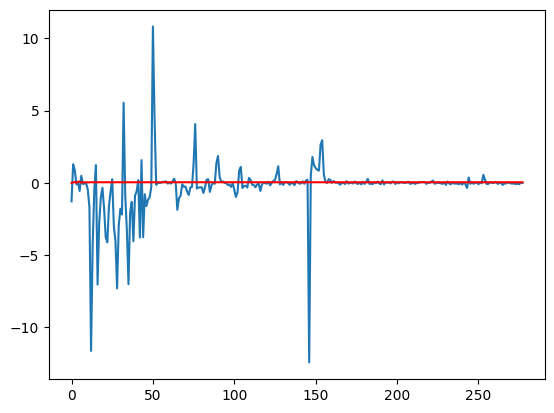

In [63]:
# create and evaluate a MA
from statsmodels.tsa.arima.model import ARIMA

# train MA
model = ARIMA(train, order=(0, 0, 12))
model_fit = model.fit()
print('Coefficients: %s' % model_fit.params)

# make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
for i in range(len(predictions)):
	print('predicted=%f, expected=%f' % (predictions[i], test[i]))

rmse = np.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot results
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

7171.9034509528965 7196.959520889648 [ 3.51978931e-02  3.70926746e-02 -1.28738913e-02 -2.99807206e-02
  3.73411555e+01]
order = (0, 0, 3)
{'aic': 7171.9034509528965, 'hqic': 7181.378559607076, 'bic': 7196.959520889648, 'RMSE': 1.7688290953361387, 'MAE': 0.6948334423957792, 'MAPE': 1.6971889549866521, 'R2': -0.028605634701067473, 'NSE': -0.028605634701067473, 'KGE': -0.8574421939905141}
predicted=0.039869, expected=-1.288589
predicted=0.025071, expected=1.284178
predicted=0.027600, expected=0.877061
predicted=0.035198, expected=-0.108655
predicted=0.035198, expected=-0.009529
predicted=0.035198, expected=-0.568806
predicted=0.035198, expected=0.484477
predicted=0.035198, expected=-0.087076
predicted=0.035198, expected=-0.044290
predicted=0.035198, expected=-0.051803
predicted=0.035198, expected=-0.475973
predicted=0.035198, expected=-1.682698
predicted=0.035198, expected=-11.651334
predicted=0.035198, expected=-4.290497
predicted=0.035198, expected=-0.471296
predicted=0.035198, expected

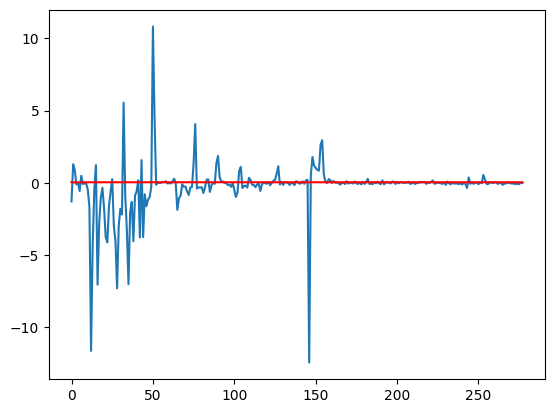

In [64]:
import numpy as np
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA

def get_best_model_results(list_orders, data, data_length):
    dict_models = {}
    for idx, order in enumerate(list_orders):
        model = ARIMA(data, order=order)
        model_fit = model.fit()
        res_train = {
            "aic": model_fit.aic,
            "hqic": model_fit.hqic,
            "bic": model_fit.bic,
        }
        pred = model_fit.predict(start=len(train), end=data_length-1, dynamic=False)
        evaluator = RegressionMetric(test, pred)
        res_test = evaluator.get_metrics_by_list_names(["RMSE", "MAE", "MAPE", "R2", "NSE", "KGE"])
        #print(order, {**res_train, **res_test})
        dict_models[idx] = [model, order, model_fit, model_fit.aic, {**res_train, **res_test}]
    list_models = sorted(dict_models.values(), key=lambda x: x[3])
    return list_models[0]

# fit model
list_orders = [(0,0,i) for i in range(3,31,3)]
model = get_best_model_results(list_orders, train, len(data))
print(model[2].aic, model[2].bic, model[2].params)
print("order =", model[1])

print(model[4])

predictions = model[2].predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
for i in range(len(predictions)):
	print('predicted=%f, expected=%f' % (predictions[i], test[i]))

rmse = np.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot results
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

## ARMA (Autoregressive Moving Average) model

c:\Users\1sosu\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\1sosu\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Coefficients: [ 3.77010663e-02  1.57979857e+00 -8.10524535e-01 -1.54953688e+00
  7.45433144e-01  2.09159013e-02  3.36585654e-02 -1.39491732e-03
  4.35070151e-03  3.70385606e+01]
predicted=-0.043219, expected=-1.288589
predicted=-0.061264, expected=1.284178
predicted=-0.038834, expected=0.877061
predicted=0.007075, expected=-0.108655
predicted=0.051944, expected=-0.009529
predicted=0.086382, expected=-0.568806
predicted=0.103063, expected=0.484477
predicted=0.101503, expected=-0.087076
predicted=0.085517, expected=-0.044290
predicted=0.061528, expected=-0.051803
predicted=0.036587, expected=-0.475973
predicted=0.016629, expected=-1.682698
predicted=0.005314, expected=-11.651334
predicted=0.003615, expected=-4.290497
predicted=0.010103, expected=-0.471296
predicted=0.021729, expected=1.225192
predicted=0.034838, expected=-7.056144
predicted=0.046123, expected=-2.809971
predicted=0.053327, expected=-1.013767
predicted=0.055560, expected=-0.343066
predicted=0.053250, expected=-1.768938
pre

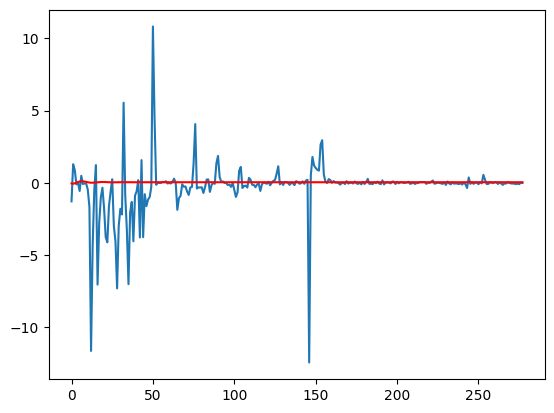

In [65]:
# create and evaluate a ARMA model
from statsmodels.tsa.arima.model import ARIMA

# fit model
model = ARIMA(train, order=(2, 0, 6)) # p =2, q = 6
model_fit = model.fit()
print('Coefficients: %s' % model_fit.params)

# make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
for i in range(len(predictions)):
	print('predicted=%f, expected=%f' % (predictions[i], test[i]))

rmse = np.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot results
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

c:\Users\1sosu\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\1sosu\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


aic:7168.109687352009, bic:7208.199399250812, params:[-2.02125706e-02 -1.47116229e-01  1.92864843e-01  8.84076543e-01
  1.43739670e-01 -2.16573532e-01 -9.24336727e-01  3.69692436e+01]
order = (3, 0, 3)
{'aic': 7168.109687352009, 'hqic': 7183.269861198696, 'bic': 7208.199399250812, 'RMSE': 1.702508156150831, 'MAE': 0.6582705896709891, 'MAPE': 2.85378284930129, 'R2': 0.04708194694709866, 'NSE': 0.04708194694709866, 'KGE': -0.15958556999034124}
predicted=-0.889251, expected=-1.288589
predicted=-0.738130, expected=1.284178
predicted=-0.841906, expected=0.877061
predicted=-0.806086, expected=-0.108655
predicted=-0.697767, expected=-0.009529
predicted=-0.798540, expected=-0.568806
predicted=-0.731157, expected=0.484477
predicted=-0.664743, expected=-0.087076
predicted=-0.750609, expected=-0.044290
predicted=-0.665596, expected=-0.051803
predicted=-0.635949, expected=-0.475973
predicted=-0.699826, expected=-1.682698
predicted=-0.609552, expected=-11.651334
predicted=-0.608942, expected=-4.290

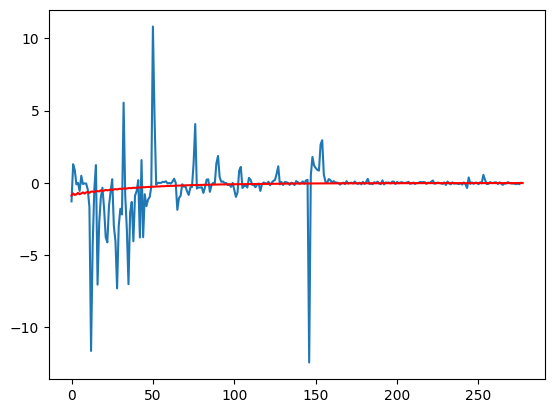

In [66]:
# fit model
list_orders = [(i,0,j) for i in range(3,13,3) for j in range(3,13,3)]
model = get_best_model_results(list_orders, train, len(data))
print(f'aic:{model[2].aic}, bic:{model[2].bic}, params:{model[2].params}')
print("order =", model[1])

print(model[4])

predictions = model[2].predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
for i in range(len(predictions)):
	print('predicted=%f, expected=%f' % (predictions[i], test[i]))

rmse = np.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot results
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

## ARIMA (Autogressive Intergrated Moving Average) model

c:\Users\1sosu\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\1sosu\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Coefficients: [-2.24439588 -2.23847221 -0.99383675  1.28603868  0.05384309 -1.23954781
 -1.05366692 -0.04666681 37.18707792]
predicted=-0.174005, expected=-1.288589
predicted=-0.021425, expected=1.284178
predicted=0.312934, expected=0.877061
predicted=-0.253420, expected=-0.108655
predicted=0.121110, expected=-0.009529
predicted=0.215985, expected=-0.568806
predicted=-0.272463, expected=0.484477
predicted=0.239212, expected=-0.087076
predicted=0.089898, expected=-0.044290
predicted=-0.234915, expected=-0.051803
predicted=0.319808, expected=-0.475973
predicted=-0.049731, expected=-1.682698
predicted=-0.139260, expected=-11.651334
predicted=0.337577, expected=-4.290497
predicted=-0.164965, expected=-0.471296
predicted=-0.015472, expected=1.225192
predicted=0.300034, expected=-7.056144
predicted=-0.243278, expected=-2.809971
predicted=0.121306, expected=-1.013767
predicted=0.205663, expected=-0.343066
predicted=-0.259814, expected=-1.768938
predicted=0.233734, expected=-3.764466
predicted

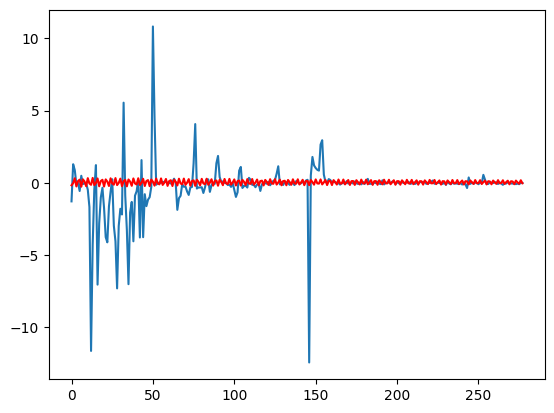

In [69]:
# create and evaluate a ARMA model
from statsmodels.tsa.arima.model import ARIMA

# fit model
model = ARIMA(train, order=(3, 1, 5))
model_fit = model.fit()
print('Coefficients: %s' % model_fit.params)

# make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
for i in range(len(predictions)):
	print('predicted=%f, expected=%f' % (predictions[i], test[i]))


print('AIC={}; BIC={}'.format(model_fit.aic, model_fit.bic))

rmse = np.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot results
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()


c:\Users\1sosu\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


aic:7170.591979383296, bic:7185.622914985218, params:[ 0.03815745 -0.99997497 37.41670618]
order = (1, 1, 1)
{'aic': 7170.591979383296, 'hqic': 7176.276272517139, 'bic': 7185.622914985218, 'RMSE': 1.7689400951259386, 'MAE': 0.695136552547346, 'MAPE': 1.7181230242263654, 'R2': -0.028734735462658145, 'NSE': -0.028734735462658145, 'KGE': -0.835730643974496}
predicted=0.045872, expected=-1.288589
predicted=0.036394, expected=1.284178
predicted=0.036032, expected=0.877061
predicted=0.036019, expected=-0.108655
predicted=0.036018, expected=-0.009529
predicted=0.036018, expected=-0.568806
predicted=0.036018, expected=0.484477
predicted=0.036018, expected=-0.087076
predicted=0.036018, expected=-0.044290
predicted=0.036018, expected=-0.051803
predicted=0.036018, expected=-0.475973
predicted=0.036018, expected=-1.682698
predicted=0.036018, expected=-11.651334
predicted=0.036018, expected=-4.290497
predicted=0.036018, expected=-0.471296
predicted=0.036018, expected=1.225192
predicted=0.036018, ex

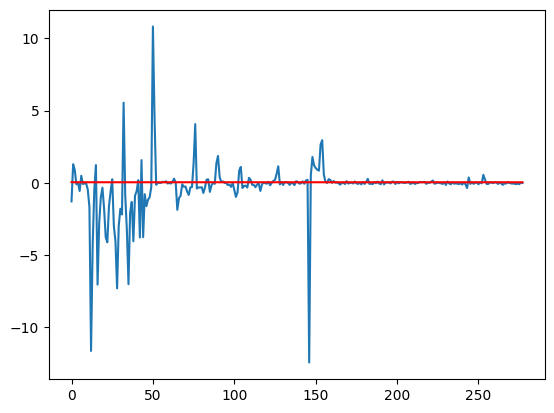

In [70]:
# fit model
list_orders = [(i,j,k) for i in range(1,7,3) for j in range(1,7,3) for k in range(1,7,3)]
model = get_best_model_results(list_orders, train, len(data))
print(f'aic:{model[2].aic}, bic:{model[2].bic}, params:{model[2].params}')
print("order =", model[1])

print(model[4])

predictions = model[2].predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
for i in range(len(predictions)):
	print('predicted=%f, expected=%f' % (predictions[i], test[i]))

rmse = np.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot results
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()